In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import pickle

import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2

from utils import *

from models import caranet
from unet import pretrained_unet

In [11]:
with open('data/validation_A2C.pickle', 'rb') as fr:
    val_img, val_mask = pickle.load(fr)

print(val_img.shape)

(100, 400, 400, 3)


In [2]:
##### Hyperparameter Settings ####
device = 'cuda' if torch.cuda.is_available() else 'cpu'
batch_size = 16
random_seed = 42
augmentation_type = 1

# model_type = 'caranet'
model_type = 'unet'

filename = f'models/pre_both_{augmentation_type}_{model_type}.pt'

if model_type == 'unet':
    mode = 'base'
elif model_type == 'caranet':
    mode = 'caranet'
#################################

In [3]:
# transform = A.Compose([
#     ToTensorV2(transpose_mask=True)
# ])

transform = False

In [4]:
train_loader, val_loader = make_dataloader('both', transform , random_seed, batch_size, mode)

train img shape : (1600, 400, 400, 3), train mask shape : (1600, 400, 400, 1)
test img shape : (200, 400, 400, 3), test mask shape : (200, 400, 400, 1)


In [5]:
img, target = next(iter(val_loader))
img = img.to(device)
target = target.to(device)

In [6]:
img.shape

torch.Size([16, 3, 400, 400])

In [7]:
if model_type == 'unet':
    model = pretrained_unet(True).to(device)
    
elif model_type == 'caranet':
    model = caranet().to(device)

In [8]:
filename = 'models/pre_both_1_unet/model_9.pt'
model.load_state_dict(torch.load(f'{filename}'))

<All keys matched successfully>

In [10]:
y_pred = model(img.float())

RuntimeError: CUDA out of memory. Tried to allocate 314.00 MiB (GPU 0; 10.75 GiB total capacity; 742.53 MiB already allocated; 142.06 MiB free; 752.00 MiB reserved in total by PyTorch)

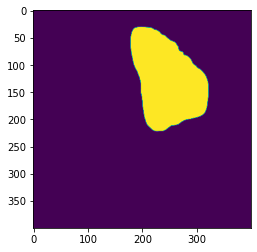

In [10]:
plt.imshow(y_pred[0].cpu().detach().numpy().transpose(1,2,0))
plt.show()

In [11]:
import torchvision.transforms as transforms

In [12]:
def resize_return(y_pred, cutoff, originsize, pad_size): ## cutoff, originsize(tuple)
    h, w = originsize
    h += cutoff
    inverse = transforms.Compose([transforms.Pad(padding=(pad_size,0), fill=0), ## padding size == 88 ? 확인 필요
                                 transforms.Resize((h,w)),
                                 transforms.Pad(padding=(0,cutoff,0,0), fill=0)]) 
    
    y_pred_inverse = inverse(y_pred)
    return y_pred_inverse